<a href="https://colab.research.google.com/github/yahito/kibana-plugin/blob/main/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация U-Net
В этом уроке мы создадим еще более качественную FCN модель на основе архитектуры UNet. Кроме использовавшихся ранее слоёв, здесь также будут участвовать Skipped Connections (проброшенные связи).

### Загрузка необходимых библиотек
Здесь мы загружаем различне библиотеки, включая TensoFlow.


In [ ]:
import numpy as np

import tensorflow as tf
# tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


### Создание UNet модели
Так как UNet имееет разветвления, мы не сможем создать её с помощью `tf.keras.Sequential`. Остаётся либо создать свой собственный класс, либо использовать функциональный API. Так как граф у нас будет статический (без каких-то условных ветвлений), и нам потом желательно визуализировать полученный граф, чтобы проверить, что мы всё соединили правильно, мы будем использовать именно функциональный API.

В архитектуре UNet для понижения размерности используется MaxPooling, а для повышения -- Conv2DTranspose (Транспонированная свёртка, Upconv). Кроме того, присутствуют проброшенные связи (skipped connections): некоторые тензоры из Энкодера конкатенируются по канальному измерению (axis=3) с тензорами из Декодера. В остальном эта модель очень похожа на обычныйю Encoder-Decoder нейросеть из предыдущего практического урока.

В отличие от классической UNet архитектуры, мы во всех слоях  будем использовать `padding='same'`, чтобы избавиться от необходимости делать crop при конкатинации тензоров из разных участков сети.

In [ ]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

### Визуализация графа модели UNet

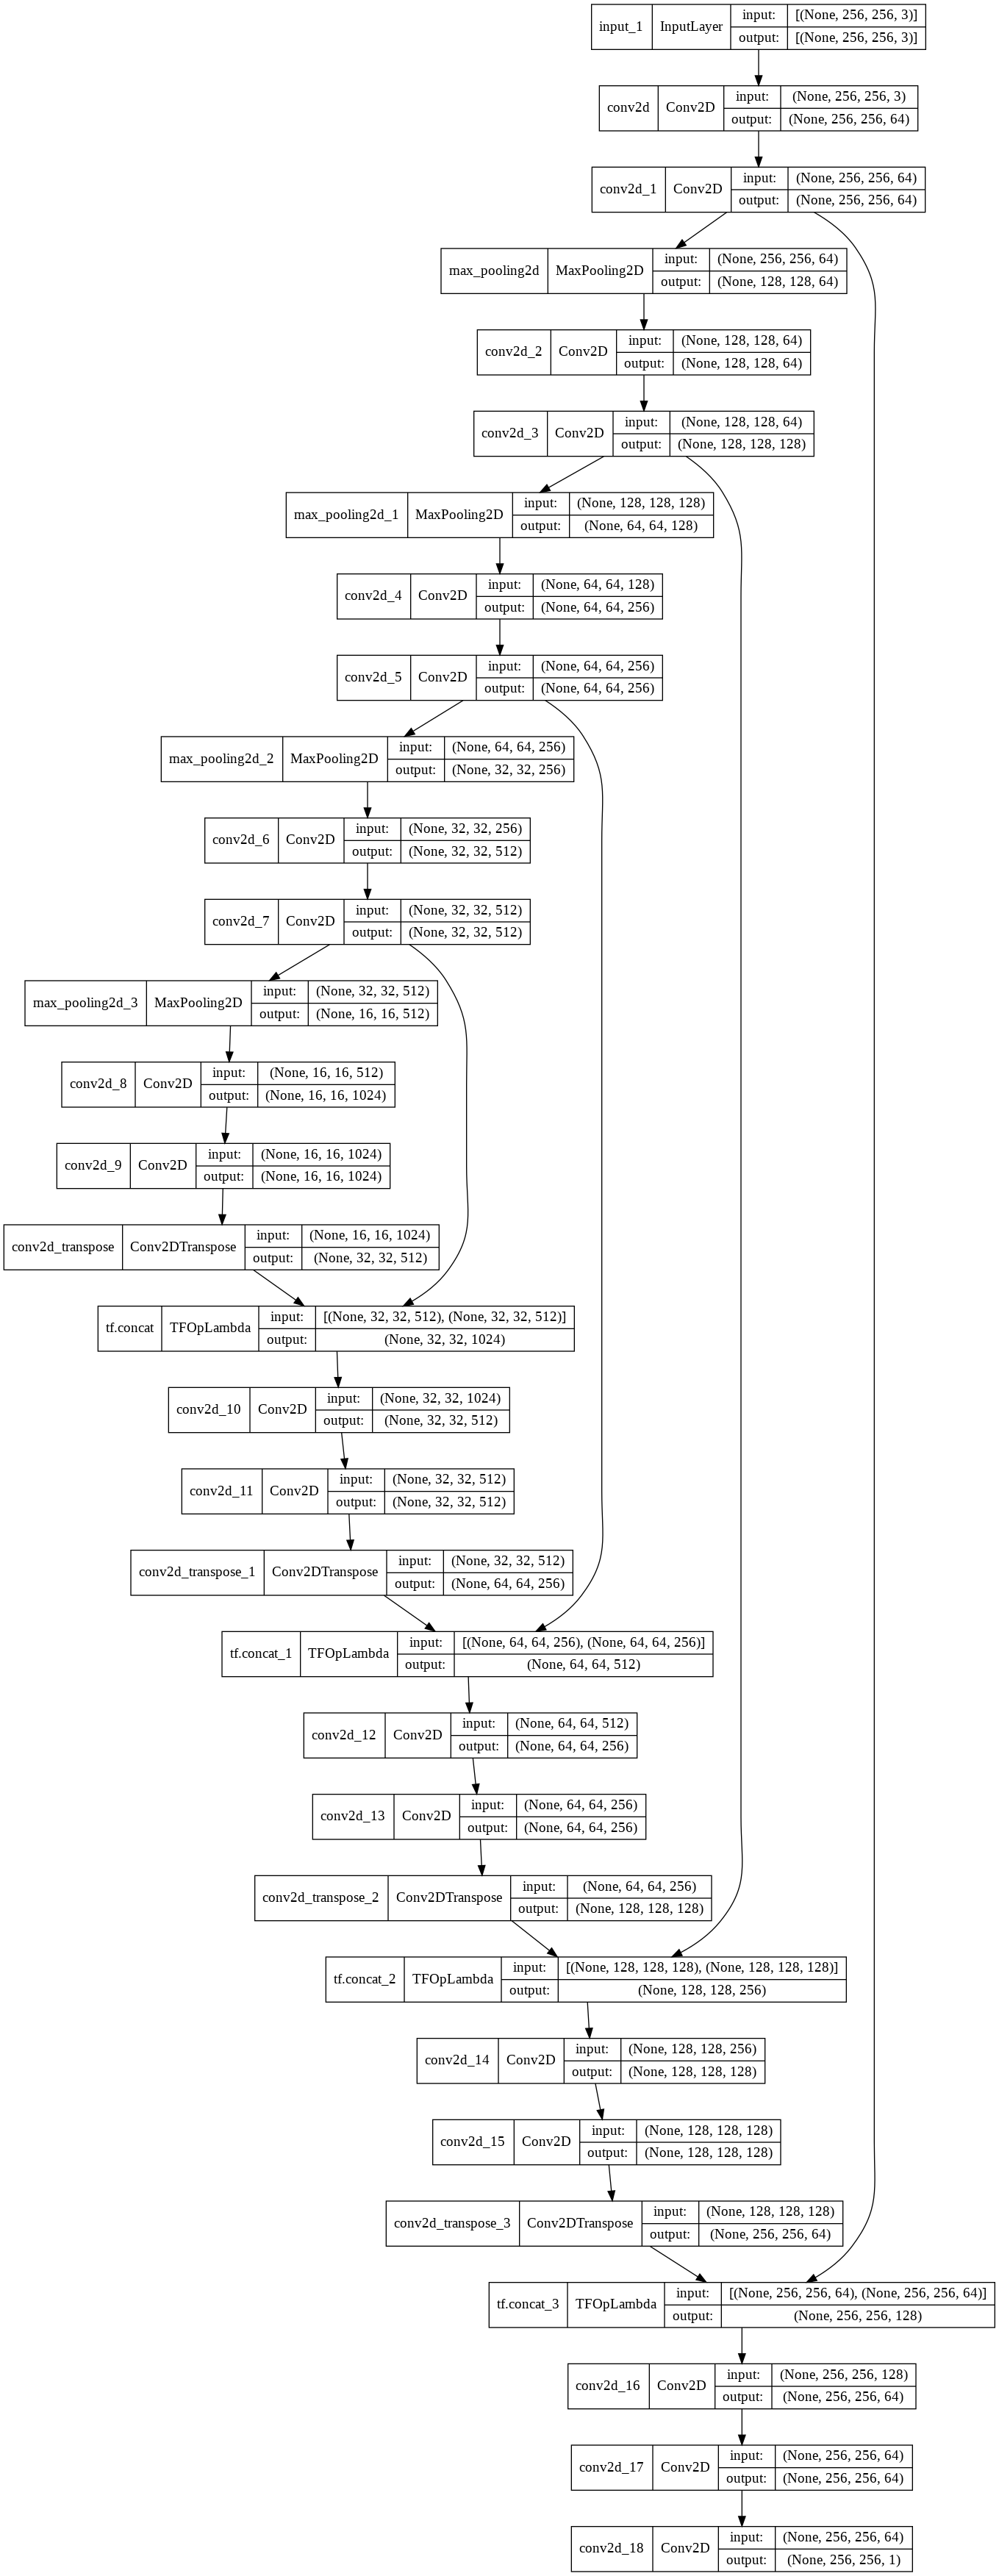

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Задания


**[ЗАДАНИЕ 1]** Вопрос: почему при создании модели UNet нам потребовались дополнительные имена для переменных типа `out1`, `out2`, `out3`, `out4`, хотя раньше мы всегда могли обойтись одним именем `out`?

**[Ответ:]** 


**[ЗАДАНИЕ 2]** Создайте новую модель, аналогичную описанной выше, в котрой замените все Pooling слои на свёрточные слои со страйдом 2, а все Conv2DTranspose слои на комбинацию Nearest Unpooling и обычного свёрточного слоя.


**[ЗАДАНИЕ 3]** Реализуйте пайплайн обучения для UNet модели: подготовка данных, лосс, обучение, тестирование. Используйте материалы из предыдущего практического урока. Обучите модель и сравните время обучения с временем обучения более простых версий FCN из предыдущих уроков.